# First approach
*08-Oct-21* 


The motion along such two-dimensional comb structure can be simulated by the following coupled Langevin equations 


<br>

\begin{align}
& x(t+\Delta t)=x(t)+\sqrt{2D_xA(y)\Delta t}\,\zeta_{x}(t),\\
& y(t+\Delta t)=y(t)+\sqrt{2D_y\Delta t}\,\zeta_{y}(t),
\end{align}

<br>


where $\zeta_{i}(t)$ ($i=\{x,y\}$) are white Gaussian noise with zero mean $\langle\zeta_{i}(t)\rangle=0$, and correlation $\langle\zeta_{i}(t)\zeta_{i}(t')\rangle=\delta(t-t')$, while the function $A(y)$ is introduced to mimic the motion along the backbone at $y=0$.  As a result, the noise $\zeta_{x}(t)$ is multiplicative. 

## A. Mimicing the Dirac $\delta$-function, with $A(y)$


The approach to replicate the Dirac $\delta$-function in this notebook is to use $A(y)=\delta(y)$ and then to employ some approximation formula for the Dirac $\delta$-function, for example $A(y) = \frac{1}{\sqrt{2\pi}\sigma}\exp(-y^2/[2\sigma^2])$ in the limit $\sigma\to 0$.


<br>


The function can by replicated by $A(y) = \frac{1}{\sqrt{2\pi}\sigma}\exp(-y^2/[2\sigma^2])$ in the limit $\sigma\to 0$, for different values for $\sigma=[1, 0.1, 0.01]$

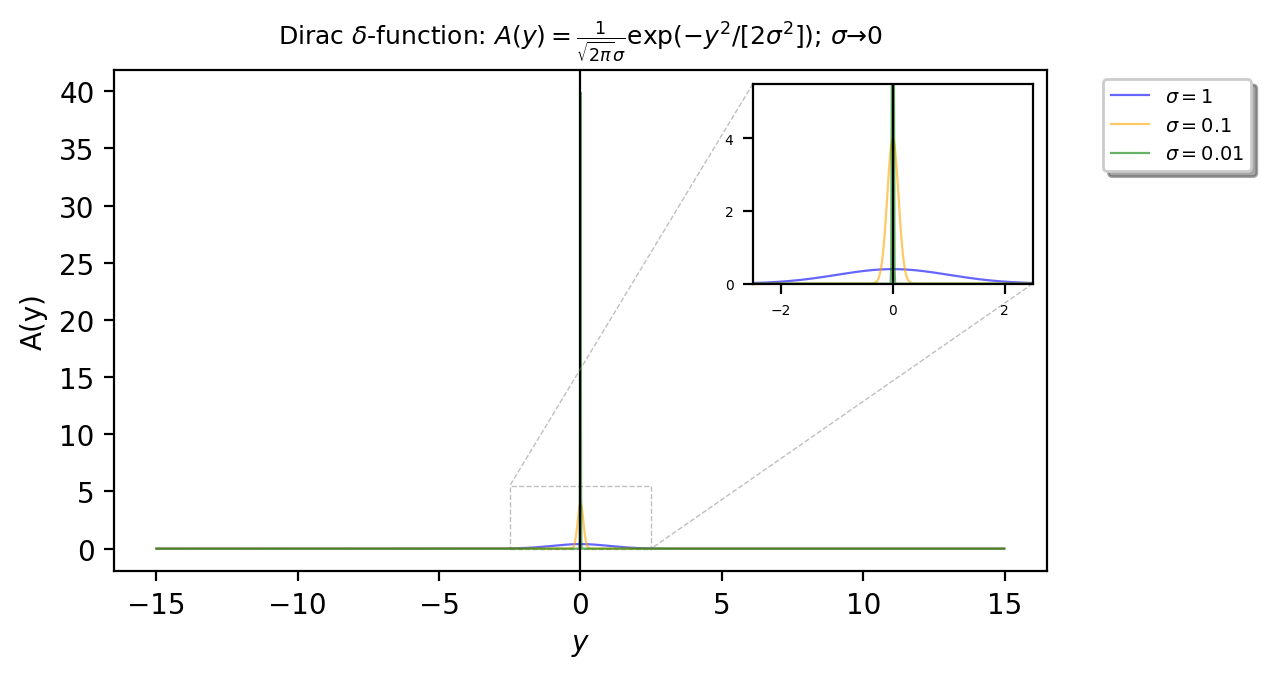

In [113]:
# Python imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
import warnings
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import plotly.graph_objs as go
import random 
warnings.filterwarnings("ignore")
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes, zoomed_inset_axes

%matplotlib inline

figure, (ax) = plt.subplots(1, 1, figsize=(7, 4), dpi=200)

y = np.arange(-15,15,0.01)

# Calculate PDF for t=1, t=2 $ t=10
x_0 = 0
sig = [1, 0.1, 0.01]
f1 = 1/(2*np.pi)**0.5 * np.exp(-(y)**2/(2*sig[0]**2)) / sig[0]
f2 = 1/(2*np.pi)**0.5 * np.exp(-(y)**2/(2*sig[1]**2)) / sig[1]
f3 = 1/(2*np.pi)**0.5 * np.exp(-(y)**2/(2*sig[2]**2)) / sig[2]

# t=1
plt.plot(y, f1, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[0]), color="blue")

# t=2
plt.plot(y, f2, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[1]), color="orange")

# t=10
plt.plot(y, f3, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[2]), color="green")


# Plot lines for reference 
plt.axvline(x=0, linewidth=0.8, alpha=1, color="black")
# plt.axvline(x=V, linewidth=0.8, alpha=0.5, color="green", linestyle='--', label=r'$V$')

plt.title(
    r"Dirac $\delta$-function: $A(y) = \frac{1}{\sqrt{2\pi}\sigma}\exp(-y^2/[2\sigma^2])$; $\sigma\to 0$",
    fontsize=9, pad=9)

# Add legend if comparing values
plt.legend(bbox_to_anchor=(1.05, 1.0),
           loc='upper left',
           fancybox=True,
           shadow=True,
           fontsize='x-small')

plt.ylabel(r"A(y)")
plt.xlabel(r"$y$")

axins = inset_axes(ax,
                  width="30%", # width = 30% of parent_bbox
                  height=1., # height : 1 inch
                  loc=1)

# t=1
axins.plot(y, f1, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[0]), color="blue")

# t=2
axins.plot(y, f2, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[1]), color="orange")

# t=10
axins.plot(y, f3, linewidth=0.8, alpha=0.6, label=r"$\sigma=${}".format(sig[2]), color="green")


# Plot lines for reference 
axins.axvline(x=0, linewidth=0.8, alpha=1, color="black")

# x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
axins.set_xlim(-2.5, 2.5)
axins.set_ylim(0, 5.5)

plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", alpha=0.5, linewidth=0.5, linestyle="--")

plt.tight_layout(pad=2.9)
ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
plt.show()

Running a simple check for the value at zero: 

In [56]:
def A(y=0, sig=0.1, pi=np.pi):
  f1 = 1/(2*np.pi)**0.5 * np.exp(-(y)**2/(2*sig**2)) / sig
  return f1

print("A(y)=", A())

A(y)= 3.989422804014327


## B. Modeling the dimensions

Main class for 2D backbone: 

In [38]:
# Python imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
import warnings
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import plotly.graph_objs as go
import random 
warnings.filterwarnings("ignore")

%matplotlib inline

# Specifying the figure parameters
font = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 10,
          'legend.handlelength': 2.}
plt.rcParams.update(params)


# Class for BM stochastic process
class Brownian_motion_Langevin:

    def A(self, y=0, sig=0.01, pi=np.pi):
      """
      Mimicing the Dirac-delta function 

      :param y   - value we are intrested in ~ A(y) 
      :param sig - scale of the Normal distribution (larger scale bigger values for 1)
      :param pi  - 3.14
      """
      # Calculate A(y)
      f1 = 1/(2*np.pi)**0.5 * np.exp(-(y)**2/(2*self.sigma**2)) / self.sigma
      # Return the square (since we use it inside the square root)
      return f1**0.5


    def solve2d(self):
      """
      Backbone solution 1
      
      Generates all step based the definition of the backbone. 
      - 1st dimension [x] - non-Brownian variable; distribution of waiting 
      - 2nd dimension [y] - Brownian motion variable 

      Returns the 2D solution of shape (dimension)(values at t time)

      :return: r
      """
      # Define the solution as [dimension, time] (in our case 2) 
      r = np.zeros((2, len(self.times)))
      
      for t in range(len(self.times)-1):
        # Calculate white gaussian noise ~ (2*Dc*dt)^0.5 * N(0, 1)
        dwx = self.sqrt_2Dx * self.sqrt_dt *np.random.normal()
        dwy = self.sqrt_2Dy * self.sqrt_dt *np.random.normal()

        # Y - axis: Langevin eq. y(t + 1) = y(t) + (2*Dc*dt)^0.5 * N(0, 1)
        r[1][t+1] = r[1][t] + dwx
        # # X - axis: Langevin eq. x(t + 1) = x(t) + A(y)*(2*Dc*dt)^0.5 * N(0, 1)
        r[0][t+1] = r[0][t] + 0.5 * (self.A(r[1][t]) + self.A(r[1][t+1]))* dwy

      self.solution2d = r


    def solve(self):
        """
        Regular Brownian Motion 

        Generates all step based the definition for BM, using 2 different approaches.  
        Both draw from a Normal Distribution ~ N(0, dt); If dt=1, it is N(0, 1) 

        B = B0 + B1*dB1 + ... Bn*dBn = x + v*dt + (2*Dc*dt)^1/2 * N(0, dt)

        :return: None
        """
        # Langevin eq. x(t + 1) = x(t) + v*dt + (2*Dc*dt)^0.5 * normal
        
        # 1st way - cumulative sum of all noises        
        dB = self.initial_y + self.drift * self.delta_t + self.sqrt_2D * self.sqrt_dt * np.random.normal(size=(len(self.times)))
        r1 = np.cumsum(dB)  

        # 2nd way - step by step addition
        r2 = np.zeros((len(self.times)))
        for t in range(len(self.times)-1):
            r2[t+1] = r2[t] + self.drift*self.delta_t + self.sqrt_2D * self.sqrt_dt *np.random.normal()

        # Append solutions
        self.numerical_solution = r1
        self.solution = r2
        
        
    def __init__(self, drift, diffusion_coefficientx, diffusion_coefficienty, sigma, initial_y, simulation_time, sampling_points):
        """

        :param drift: External force - drift
        :param diffusion_coefficient:
        :param initial_y: 1
        :param delta_t: dt - change in time - size of each interval
        :param simulation_time: total time for simulation
        :param sigma: scaling factor for Dirac mimic function, A(y). For larger scale, bigger values for y in 0
        """
        # Initial parameters 
        self.drift = drift
        self.diffusion_coefficientx = diffusion_coefficientx
        self.diffusion_coefficienty = diffusion_coefficienty
        self.initial_y = initial_y
        self.sigma = sigma

        # Define time 
        self.simulation_time = simulation_time
        self.sampling_points = sampling_points

        # Get dt - change in time 
        self.times = np.arange(0,simulation_time+1,1)
        self.delta_t = self.times[1] - self.times[0]

        # Speed up calculations
        self.sqrt_dt = self.delta_t**0.5
        self.sqrt_2Dx = (2*self.diffusion_coefficientx)**0.5
        self.sqrt_2Dy = (2*self.diffusion_coefficienty)**0.5

        # Simulate the diffusion process
        self.numerical_solution = []
        self.solution = []
        self.solution2d = []
        
        # Solve which one
        self.solve2d()

Define start parameters and run/plot *ensemble* with $10^4$ processes: 
- $n = 10^4$ - Number of simulations
- $Dx = Dy = 0.05$ - diffusion coefficient for $Dx$ and $Dy$
- $dt=1$ - interval size or size step
- $y0 = 0$  - starting point on y axis (theoretical 0 for BM)
- $tt = 10^4$  - total time for each simulation
- $\sigma=0.1$ - scaling factor for mimiced Dirac$-\delta$ function, $A(y)$

In [93]:
# Define parametrs for BM process
n = 10**4 # Size of Ensemble 
V = 0  # Drift for the diffusion process, v - external force (drift)
Dx = Dy = 0.005  # Di - diffusion coefficient
interval_size = 1 # dt = interval_size
y0 = 0  # y0 - starting point
tt = 10_000  # tt - total time for each simulation
sigma = 0.1 # scaling factor for Dirac mimic function, A(y)


# Run simulations
motions = []
for i in range(0, n):
  motions.append(Brownian_motion_Langevin(drift=V,
                                          diffusion_coefficientx=Dx,
                                          diffusion_coefficienty=Dy,
                                          sigma=sigma,
                                          initial_y=y0,
                                          simulation_time=tt,
                                          sampling_points=interval_size))

Plot the two trajectories for random process out of the Ensemble: 

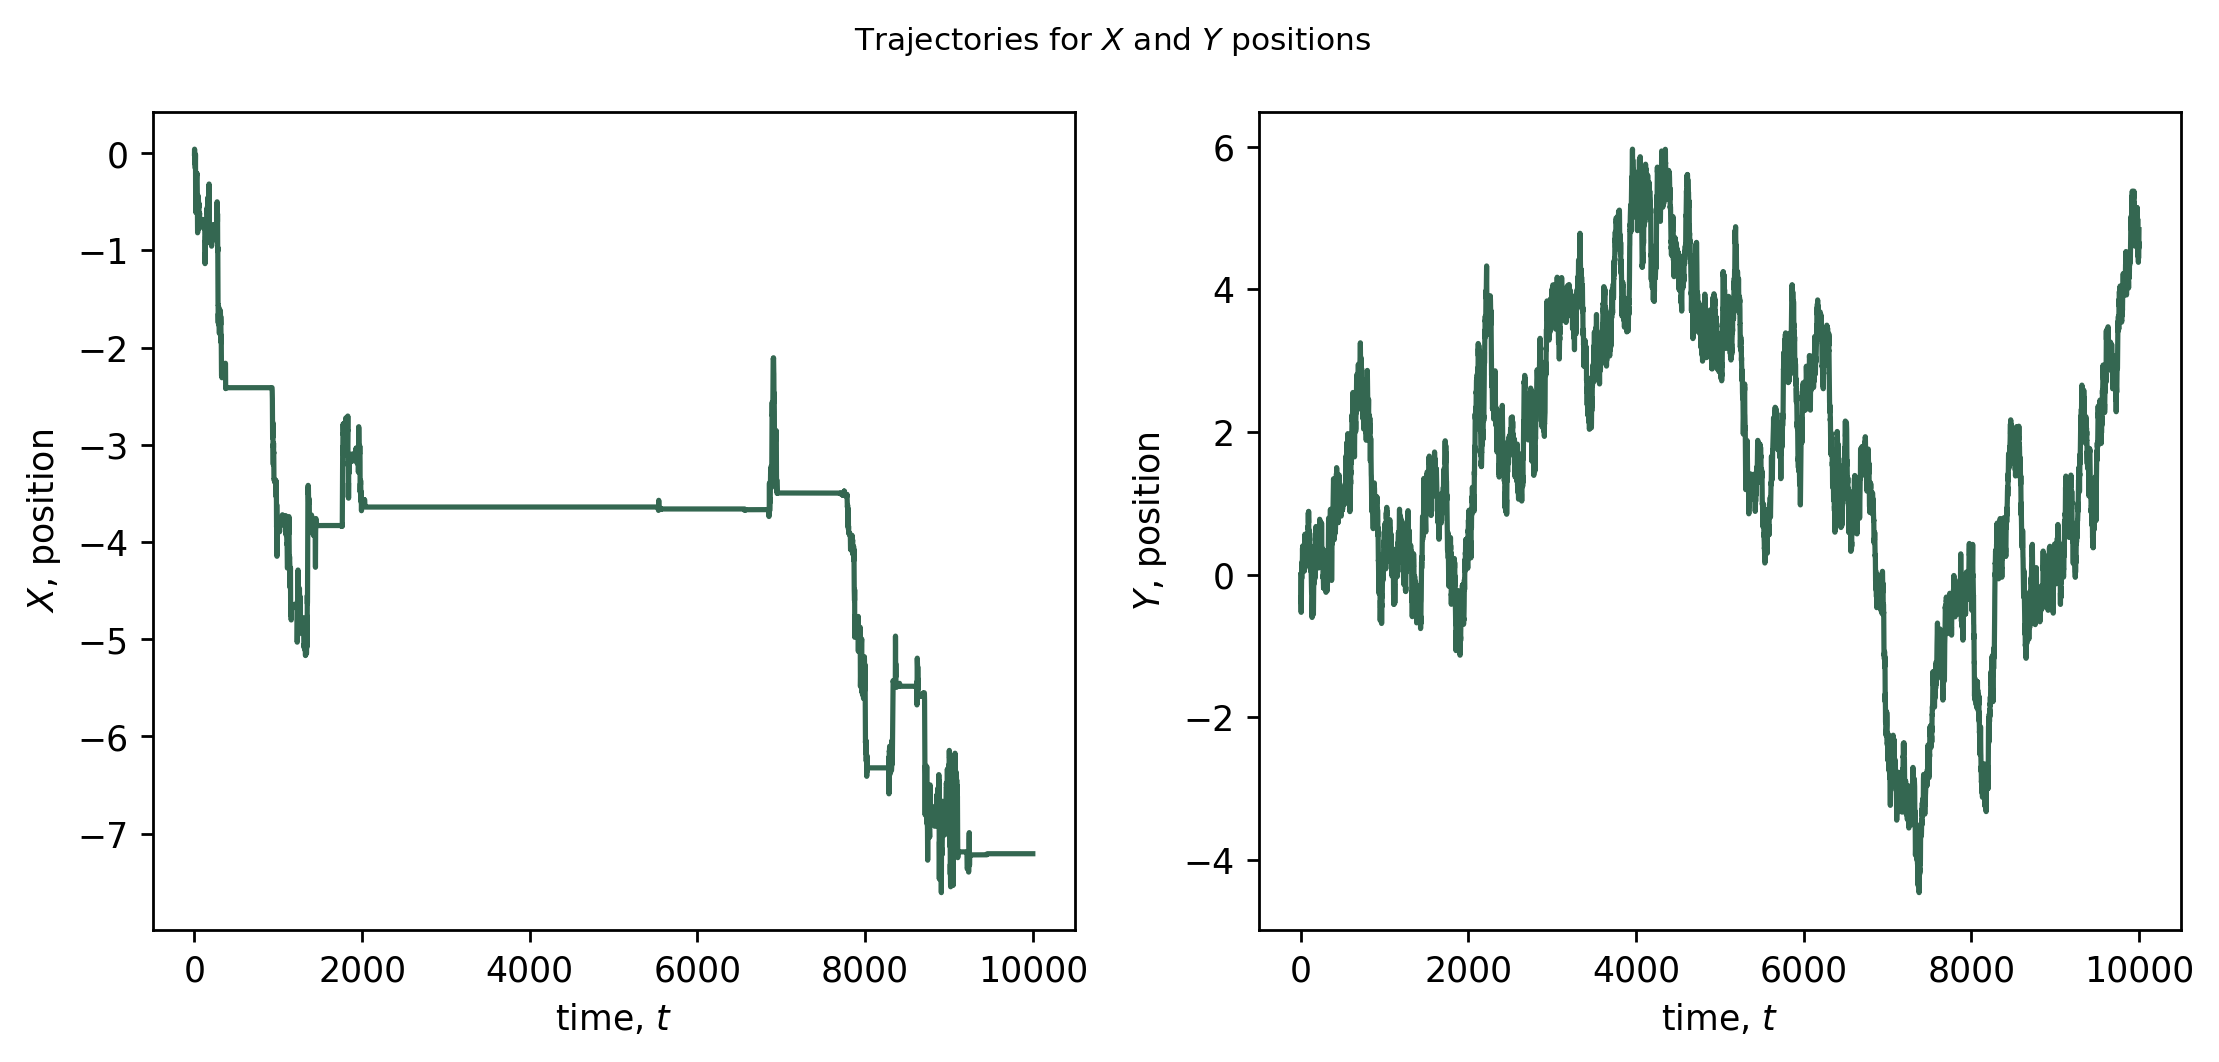

In [94]:
# Matplotlib subplot
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), dpi=250)
plt.suptitle(r"Trajectories for $X$ and $Y$ positions", fontsize=9, y=1.05)

# Pick random motion
rand_motion = random.randint(0, n)
r = motions[rand_motion].solution2d

# Plot the two axis
time = np.arange(0,tt+1,1)

ax1.plot(time, r[0], color="#346751")
ax1.set_xlabel(r'time, $t$')
ax1.set_ylabel(r'$X$, position')

ax2.plot(time, r[1], color="#346751")
ax2.set_xlabel(r'time, $t$')
ax2.set_ylabel(r'$Y$, position')

plt.tight_layout()
plt.show()

Check how many times the random variable hits zero: 

In [95]:
# Random check
count = 0
for i in range(0, tt+1, 1):
  if np.round(r[1][i]) == 0.0:
    # print("X touches zero at:  ", i)
    count+=1

print("\nTotal of {} times".format(count))


Total of 1817 times


### Results

2D comb random walk:

In [96]:
# Plotly, interactive plot
from plotly.offline import plot, iplot, init_notebook_mode
from IPython.core.display import display, HTML
init_notebook_mode(connected = True)
config={'showLink': False, 'displayModeBar': False}

trace = go.Scatter(
    x=r[0],
    y=r[1],
    mode='lines',
    name="Trajectories-comb",
    opacity=0.8, 
    hovertemplate =
    '<i>Y</i>: %{y:.1f}'+
    '<br><i>X</i>: %{x:.1f}<br>',
    line=dict(color="#346751", 
              width=2))

layout = go.Layout(title="2D backbone random walk",
                   title_x=0.5,
    margin={'l': 50, 'r': 50, 'b': 50, 't': 50},
    autosize=False,
    width=520,
    height=500,
    xaxis_title='<i>X</i>, position',
    yaxis_title='<i>Y</i>, position',
    plot_bgcolor='#fff',
    yaxis=dict(mirror=True,
                ticks='outside', 
                showline=True,
                showspikes = False,
                linecolor='#000',
               tickfont = dict(size=11)),
    xaxis=dict(mirror=True,
                ticks='outside',
                showline=True,
                linecolor='#000',
                tickfont = dict(size=11))
)

data = [trace]

figa = go.Figure(data=data, layout=layout)


plot(figa, filename = 'fig1_a.html', config = config)
display(HTML('fig1_a.html'))

Save both distributions:

In [97]:
dist_x = []
dist_y = []
for i in range(0, n):
    dist_x.append(motions[i].solution2d[0])
    dist_y.append(motions[i].solution2d[1])

print("Dist. for X has shape: {x}".format(x=np.shape(dist_x)))
print("Dist. for Y has shape: {y}".format(y=np.shape(dist_x)))

Dist. for X has shape: (10000, 10001)
Dist. for Y has shape: (10000, 10001)


## C. Mean square displacement 

The returning probability of the Brownian particle from the finger to the backbone corresponds to the waiting time PDF for the particle moving along the backbone, so for Brownian motion it scales as $\sim t^{-3/2}$. From the CTRW theory we know that such waiting times leads to anomalous diffusion with MSD given by $\langle x^{2}(t)\rangle\sim t^{1/2}$. 

Calculate the MSD for both axis: 

In [98]:
# Calculate MSD for X
no_simulations, no_points = np.shape(dist_x)
msd_x = []

for t in range(no_points-1):
  value_x = [dist_x[i][t] for i in range(n)] 
  value = np.dot(value_x, value_x) / n    # dot product / ensemble size
  msd_x.append(value)

# Calculate MSD for Y
no_simulations, no_points = np.shape(dist_y)
msd_y = []

for t in range(no_points-1):
  value_y = [dist_y[i][t] for i in range(n)] 
  value = np.dot(value_y, value_y) / n    # dot product / ensemble size
  msd_y.append(value)

# Convert to arrays
msd_x = np.array(msd_x)
msd_y = np.array(msd_y)

### Results

#### $\langle x^{2}(t)\rangle\sim t^{1/2}$

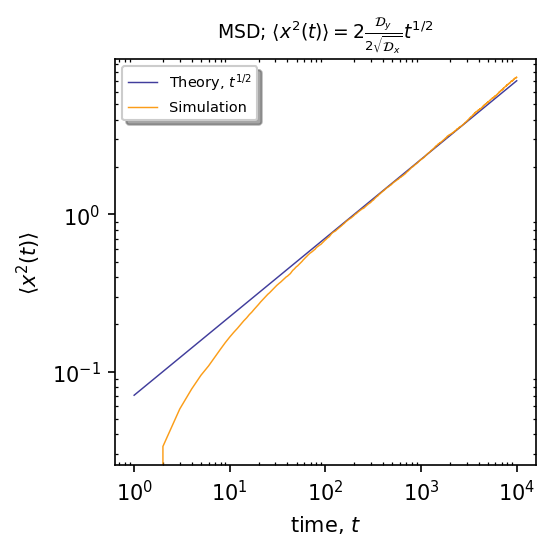

In [111]:
# Theoretical vs. Ensemble
figure, (ax) = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.arange(1, tt+1)
x0 = 0   # mean from PDF

factor = 2*Dy/(2*Dx**0.5)

ax.plot(x, (lambda x: factor*x**0.5)(x), linewidth=0.7, alpha=0.9, label=r"Theory, $t^{1/2}$", color="#2C2891")
ax.plot(x, msd_x, '#FB9300',  markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation", markevery=30)


# Add legend if comparing values
plt.legend(loc='upper left',
           fancybox=True,
           shadow=True,
           fontsize='x-small')

ax.set_yscale('log')
ax.set_xscale('log')

plt.ylabel(r"$\langle x^2(t) \rangle$")
plt.xlabel(r"time, $t$")
plt.title(r"MSD; $\langle x^2(t)\rangle=2 \frac{\mathcal{D}_y}{2\sqrt{\mathcal{D}_x}}t^{1/2}$", fontsize=9, pad=10)
plt.tight_layout(pad=1.9)
ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
plt.show()

#### $\langle y^2(t)\rangle \sim t^1$. 

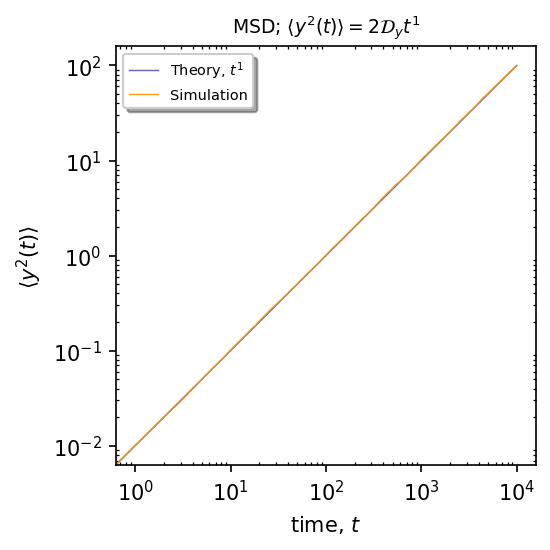

In [112]:
# Theoretical vs. Ensemble
figure, (ax) = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.arange(0, tt)
x0 = 0   # mean from PDF

ax.plot(x, (lambda x: 2*Dy*x**1)(x), linewidth=0.7, alpha=0.7, label=r"Theory, $t^1$", color="#2C2891")
ax.plot(x, msd_y, '#FB9300',  markersize=1, linewidth=0.7, alpha=0.9, label=r"Simulation", markevery=30)

# Add legend if comparing values
plt.legend(loc='upper left',
           fancybox=True,
           shadow=True,
           fontsize='x-small')

ax.set_yscale('log')
ax.set_xscale('log')

plt.ylabel(r"$\langle y^2(t) \rangle$")
plt.xlabel(r"time, $t$")
plt.title(r"MSD; $\langle y^2(t)\rangle=2\mathcal{D}_yt^{1}$", fontsize=9)
plt.tight_layout(pad=1.9)
ax.tick_params(direction="in", which='minor', length=1.5, top=True, right=True)
plt.show()